# 0. Заголовок и цель

Markdown

название проекта

что решаем: предсказание alpha (0..255), метрика MSE

данные: MAGICK (train), Kaggle test (orig_1024)

## 1. Импорты и глобальные настройки

Импорты, настройки PIL, базовые зависимости

In [1]:
import os
import io
import sys
import base64
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

Image.MAX_IMAGE_PIXELS = None

Все параметры меняются здесь

In [2]:
Image.MAX_IMAGE_PIXELS = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# пути
TRAIN_CSV = Path("data/splits/train.csv")
VAL_CSV   = Path("data/splits/val.csv")
TEST_ROOT = Path("data/test_dataset/orig_1024")  # твой тест Kaggle
MODEL_DIR = Path("outputs/experiments/exp_001")
MODEL_DIR.mkdir(parents=True, exist_ok=True)


TRAIN_SIZE = (512, 512)
VAL_SIZE   = (1024, 1024)
TRAIN_BATCH = 4
VAL_BATCH   = 1

LIMIT_DATA = 1000
   
NUM_EPOCHS = 8  # Увеличено для лучшей конвергенции с новым loss
LR = 1e-4
RUN_TRAINING = True

## 2. Датасеты и аугментации


In [3]:
class CsvAlphaDataset(Dataset):
    """
    Ожидает CSV с колонками:
      - image_path
      - alpha_path
    Возвращает dict как в baseline:
      {"img": tensor, "mask": tensor}
    """
    def __init__(self, csv_path: Path, size=(1024, 1024), normalize=True, augment=None, limit=LIMIT_DATA,
                 xray_aug_p=0.5, xray_strength_range=(0.25, 0.65), xray_floor_range=(0.60, 0.85),
                 xray_blur_k=1, xray_gamma_range=(1.6, 2.6), xray_black_level_range=(0.00, 0.08)):
        self.csv_path = Path(csv_path)
        self.df = pd.read_csv(self.csv_path)

        if limit is not None:
            self.df = self.df.head(int(limit)).reset_index(drop=True)
            
        self.size = size
        self.augment = augment
        
        # Параметры x-ray alpha аугментации (применяется только для train, когда augment не None)
        self.xray_aug_p = xray_aug_p
        self.xray_strength_range = xray_strength_range
        self.xray_floor_range = xray_floor_range
        self.xray_blur_k = xray_blur_k
        self.xray_gamma_range = xray_gamma_range
        self.xray_black_level_range = xray_black_level_range

        use_resize = False

        if normalize:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())
            self.image_transforms_before_norm = transforms.Compose(transform_list)
            self.image_normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        else:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())
            self.image_transforms_before_norm = transforms.Compose(transform_list)
            self.image_normalize = None

        # Для масок используем NEAREST интерполяцию (сохраняет чёткие границы) и fill=0 (прозрачность)
        mask_transform_list = []
        if use_resize:
            mask_transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST))
        mask_transform_list.append(transforms.ToTensor())
        self.mask_transforms = transforms.Compose(mask_transform_list)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = Path(row["image_path"])
        mask_path = Path(row["alpha_path"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.augment is not None:
            img, mask = self.augment(img, mask)

        img_t_before_norm = self.image_transforms_before_norm(img)
        mask_t = self.mask_transforms(mask)

        if self.augment is not None:
            alpha = mask_t[0]
            rgb01 = img_t_before_norm
            alpha = xray_alpha_from_texture(
                alpha,
                rgb01,
                p=self.xray_aug_p,
                strength_range=self.xray_strength_range,
                floor_range=self.xray_floor_range,
                blur_k=self.xray_blur_k,
                gamma_range=self.xray_gamma_range,
                black_level_range=self.xray_black_level_range
            )
            mask_t = alpha.unsqueeze(0)
        
        # ГАРАНТИРУЕМ фон = 0: жёсткая правка после всех трансформаций и аугментаций
        # Это простая страховка, которая часто полностью убивает haze-обучение
        gt_alpha = mask_t[0]  # (H, W)
        obj = (gt_alpha > 0.1).float()
        mask_t[0] = gt_alpha * obj  # фон ровно 0
        
        if self.image_normalize is not None:
            img_t = self.image_normalize(img_t_before_norm)
        else:
            img_t = img_t_before_norm

        return {"img": img_t, "mask": mask_t}


class TestImageDataset(Dataset):
    def __init__(self, root: Path, size=(1024, 1024)):
        self.root = Path(root)
        self.images = sorted([p for p in self.root.iterdir() if p.is_file()])
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = Image.open(path).convert("RGB")
        return {"path": path.name, "img": self.transform(img)}

In [4]:
class JointAugment:
    def __init__(self, size=512, p_flip=0.5, p_rotate=0.0, max_rotate=10, p_color=0.7):
        self.crop_size = size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.max_rotate = max_rotate
        self.p_color = p_color

    def __call__(self, img_pil, mask_pil):
        # random crop (одинаково для img и mask)
        i, j, h, w = transforms.RandomCrop.get_params(img_pil, output_size=(self.crop_size, self.crop_size))
        img_pil = TF.crop(img_pil, i, j, h, w)
        mask_pil = TF.crop(mask_pil, i, j, h, w)

        # flip
        if random.random() < self.p_flip:
            img_pil = TF.hflip(img_pil)
            mask_pil = TF.hflip(mask_pil)

        # rotate с явным fill для корректной обработки краёв
        if self.p_rotate and random.random() < self.p_rotate:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            # fill=255 для RGB (белый фон) - уменьшает "туман" на светлом фоне
            # fill=0 для mask (прозрачность)
            # expand=False: не расширяем изображение, обрезаем углы
            # Для RGB: BILINEAR интерполяция, для mask: NEAREST (сохраняет чёткие границы)
            img_pil = TF.rotate(img_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=255, expand=False)
            mask_pil = TF.rotate(mask_pil, angle, interpolation=InterpolationMode.NEAREST, fill=0, expand=False)

        # color jitter only for img
        if random.random() < self.p_color:
            b = random.uniform(0.85, 1.15)
            c = random.uniform(0.85, 1.15)
            s = random.uniform(0.85, 1.15)
            img_pil = TF.adjust_brightness(img_pil, b)
            img_pil = TF.adjust_contrast(img_pil, c)
            img_pil = TF.adjust_saturation(img_pil, s)

        return img_pil, mask_pil

### X-ray alpha аугментация - УСИЛЕННАЯ версия

**Цель**: МАКСИМАЛЬНАЯ детализация внутри объекта.

**Параметры (УСИЛЕННЫЕ)**:
- `p=0.9` — 90% примеров (было 0.8)
- `blur_k=10` — ЕЩЁ меньше размытия (было 15)
- `floor=(0.25, 0.55)` — БОЛЬШЕ контраста (было 0.30-0.60)
- `strength=(0.50, 0.90)` — СИЛЬНЕЕ затемнение (было 0.40-0.85)
- `gamma=(2.2, 3.5)` — РЕЗЧЕ контраст (было 2.0-3.2)
- `black_level=(0.10, 0.22)` — БОЛЬШЕ чёрного (было 0.08-0.18)

**Веса компонентов (УСИЛЕННЫЕ)**:
- Low-freq (luma): **0.05-0.20** (МИНИМУМ, было 0.1-0.3)
- High-freq (градиенты): **0.60-0.90** (МАКСИМУМ!, было 0.5-0.8)
- Variance: 0.15-0.40

**Blur**:
- Градиенты: max(2, 10//6) = **2px** (минимум!)
- Финальный: max(3, 10//4) = **3px** (минимум!)

**Результат**: Density map на 60-90% состоит из градиентов → максимальная структура!

In [5]:
# X-ray alpha аугментация: УСИЛЕННАЯ версия для максимальной детализации
# Увеличены веса градиентов до 0.6-0.9 для максимума структуры

def sobel_mag(x):  # x: (H,W)
    """Вычисляет магнитуду градиента через Sobel оператор"""
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def blur_avg(x, k=41):  # x: (H,W)
    """Сглаживает тензор через average pooling"""
    H, W = x.shape
    pad = k//2
    x_padded = F.avg_pool2d(x[None,None], k, 1, pad)[0,0]
    if x_padded.shape[0] != H or x_padded.shape[1] != W:
        x_padded = x_padded[:H, :W]
    return x_padded

def xray_alpha_from_texture(
    alpha01,
    rgb01,
    p=0.5,
    strength_range=(0.25, 0.65),   
    floor_range=(0.60, 0.85),      
    blur_k=41,                     
    gamma_range=(1.6, 2.6),        
    black_level_range=(0.00, 0.08),
):
    """X-ray эффект на основе текстуры изображения - УСИЛЕННАЯ версия"""
    if torch.rand(()) > p:
        # Даже если аугментация не применяется, гарантируем фон = 0
        obj = (alpha01 > 0.1).float()
        return alpha01 * obj

    H, W = alpha01.shape
    obj = (alpha01 > 0.1).float()

    r, g, b = rgb01[0], rgb01[1], rgb01[2]
    luma = (0.299*r + 0.587*g + 0.114*b).clamp(0,1)

    # Low-freq: размытая luma для базовой структуры
    luma_low = blur_avg(luma, k=blur_k)
    luma_low = luma_low[:H, :W]
    luma_low = luma_low / (luma_low.max() + 1e-6)

    # High-freq: градиенты с небольшим blur для "рентген-структуры"
    # Идея: смесь low-freq + high-freq даёт "рентген-структуру"
    grad = sobel_mag(luma)
    # Применяем небольшой blur к градиентам (меньше чем к luma)
    grad_blur_k = max(3, blur_k // 3)  # Для blur_k=1 будет k=3 (минимальный blur для градиентов)
    grad_smooth = blur_avg(grad, k=grad_blur_k)
    grad_smooth = grad_smooth[:H, :W]
    grad_smooth = grad_smooth / (grad_smooth.max() + 1e-6)

    # Density map: смесь low-freq (luma) + high-freq (grad) для "рентген-структуры"
    # Формула: dens = 0.7 * blur(luma) + 0.3 * blur(sobel(luma))
    # Но с небольшими вариациями для разнообразия
    w_low = float(torch.empty(1).uniform_(0.65, 0.75).item())   # low-freq (luma): 0.65-0.75
    w_high = float(torch.empty(1).uniform_(0.25, 0.35).item())  # high-freq (grad): 0.25-0.35
    dens = (w_low * luma_low + w_high * grad_smooth).clamp(0, 1)
    
    # Финальный blur - минимальный для сохранения структуры
    dens = blur_avg(dens, k=max(1, blur_k//4))  # Для blur_k=1 будет k=1
    dens = dens[:H, :W]

    # ВАЖНО: применяем density только в obj (гарантируем, что фон не затронут)
    d = dens * obj
    dmin = d[obj>0.5].min() if (obj>0.5).any() else d.min()
    dmax = d[obj>0.5].max() if (obj>0.5).any() else d.max()
    d = (d - dmin) / (dmax - dmin + 1e-6)
    d = d.clamp(0,1)

    gamma = float(torch.empty(1).uniform_(*gamma_range).item())
    d = d.pow(gamma)

    strength = float(torch.empty(1).uniform_(*strength_range).item())
    floor = float(torch.empty(1).uniform_(*floor_range).item())
    black_lv = float(torch.empty(1).uniform_(*black_level_range).item())

    alpha_new = alpha01 * (1.0 - strength * d * obj)
    alpha_new = alpha_new - black_lv * d * obj
    alpha_new = alpha_new * obj + alpha01 * (1.0 - obj)

    floor_tensor = torch.tensor(floor, device=alpha01.device, dtype=alpha01.dtype)
    alpha_new = torch.where(obj > 0.5, torch.maximum(alpha_new, floor_tensor), alpha_new)
    
    # ГАРАНТИРУЕМ фон = 0: жёсткая правка после всех операций
    alpha_new = alpha_new * obj
    
    return alpha_new.clamp(0,1)

Геометрия синхронно img+mask, фотометрия только img

Создадим Dataloaders для аугментации train данных

In [6]:
train_aug = JointAugment(size=512, p_flip=0.5, p_rotate=0.3, max_rotate=10, p_color=0.7)

# УСИЛЕННАЯ X-ray аугментация для МАКСИМАЛЬНОЙ детализации alpha-mask
# - Увеличена сила затемнения
# - Снижен floor (допускаем более тёмные зоны) - ЕЩЁ УМЕНЬШЕНО для максимального контраста
# - Blur установлен на 1 (максимум деталей, минимум размытия)
# - Увеличен black_level (больше чёрных зон)
# - Увеличен gamma для более резкого контраста и детализации
train_ds = CsvAlphaDataset(
    TRAIN_CSV, 
    size=TRAIN_SIZE, 
    augment=train_aug, 
    limit=LIMIT_DATA,
    xray_aug_p=0.9,  # 90% примеров (было 0.8)
    xray_strength_range=(0.50, 0.90),  # УВЕЛИЧЕНО с (0.40, 0.85) - больше затемнения!
    xray_floor_range=(0.10, 0.35),     # ЕЩЁ УМЕНЬШЕНО с (0.15, 0.45) - максимальный контраст, больше тёмных зон!
    xray_blur_k=1,                      # УСТАНОВЛЕНО на 1 - максимум деталей, минимум размытия!
    xray_gamma_range=(2.5, 4.0),       # ЕЩЁ УВЕЛИЧЕНО с (2.2, 3.5) - максимально резкий контраст для детализации!
    xray_black_level_range=(0.10, 0.22) # УВЕЛИЧЕНО с (0.08, 0.18) - больше чёрного!
)

val_ds = CsvAlphaDataset(VAL_CSV, size=VAL_SIZE, augment=None, limit=LIMIT_DATA)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=0, pin_memory=True)

### Стратегия аугментации

**Текущий подход**: Комбинированная стратегия для баланса между бинарными масками и полутонами

1. **80% примеров** — X-ray аугментация (xray_aug_p=0.8)
   - Создаёт полутона внутри объекта
   - Увеличены веса градиентов (high-freq) для большей детализации
   - Уменьшен blur для сохранения структуры

2. **20% примеров** — чистый MAGICK (без аугментации)
   - Бинарные маски для чётких границ
   - Помогает модели различать "где точно объект/фон"

**Параметры для детализации**:
- `blur_k=25` (было 41) — меньше размытия = больше деталей
- `w2` (градиенты) увеличено до 0.4-0.7 — больше структуры внутри
- `floor` снижен до 0.50-0.80 — больше контраста внутри объекта
- `black_level` увеличен — больше тёмных зон

### Диагностика: проверка X-ray аугментации в train loader

**Цель**: убедиться, что x-ray аугментация применяется и создаёт полутона внутри объекта.

**Что проверяем**:
- Доля полутонов (mid_frac) в GT масках train loader должна быть выше, чем в оригинальных MAGICK масках
- Фон должен оставаться близким к 0
- Внутри объекта должен быть контраст (не бинарные значения)

In [7]:
# Диагностика train loader: проверяем, что x-ray аугментация работает
print("=== Диагностика train loader: проверка X-ray аугментации ===\n")

# Берём несколько батчей из train_loader
n_batches = 5
mid_frac_list = []
bg_quantile_list = []
obj_min_list = []
obj_max_list = []

for i, batch in enumerate(train_loader):
    if i >= n_batches:
        break
    
    masks = batch["mask"]  # (B, 1, H, W) float [0,1]
    
    for b in range(masks.shape[0]):
        mask = masks[b, 0].cpu().numpy()  # (H, W)
        
        # Доля полутонов (значения между 0.05 и 0.95)
        mid_frac = np.mean((mask > 0.05) & (mask < 0.95))
        mid_frac_list.append(mid_frac)
        
        # Фон (нижний 1% квантиль)
        bg_q = np.percentile(mask, 1)
        bg_quantile_list.append(bg_q)
        
        # Внутри объекта (где mask > 0.1)
        obj_pixels = mask[mask > 0.1]
        if len(obj_pixels) > 0:
            obj_min_list.append(obj_pixels.min())
            obj_max_list.append(obj_pixels.max())

# Статистика
print(f"Проверено батчей: {n_batches}")
print(f"Проверено масок: {len(mid_frac_list)}\n")

print("Результаты:")
print(f"1. Доля полутонов (mid_frac):")
print(f"   Среднее: {np.mean(mid_frac_list):.4f}")
print(f"   Медиана: {np.median(mid_frac_list):.4f}")
print(f"   Мин/Макс: {np.min(mid_frac_list):.4f} / {np.max(mid_frac_list):.4f}\n")

print(f"2. Фон (1% квантиль):")
print(f"   Среднее: {np.mean(bg_quantile_list):.6f}")
print(f"   Медиана: {np.median(bg_quantile_list):.6f}\n")

print(f"3. Внутри объекта (где mask > 0.1):")
print(f"   Минимум (среднее): {np.mean(obj_min_list):.4f}")
print(f"   Максимум (среднее): {np.mean(obj_max_list):.4f}")
print(f"   Контраст (max-min): {np.mean(obj_max_list) - np.mean(obj_min_list):.4f}\n")

print("Ожидаемые значения (если x-ray аугментация работает):")
print("- mid_frac должна быть > 0.15 (в идеале 0.2-0.4)")
print("- bg_quantile должна быть < 0.05")
print("- Контраст внутри объекта должен быть > 0.2 (разные значения альфы)")
print("\nЕсли mid_frac < 0.1 → x-ray аугментация НЕ работает или слишком слабая!")

=== Диагностика train loader: проверка X-ray аугментации ===

Проверено батчей: 5
Проверено масок: 20

Результаты:
1. Доля полутонов (mid_frac):
   Среднее: 0.3281
   Медиана: 0.3448
   Мин/Макс: 0.0196 / 0.7600

2. Фон (1% квантиль):
   Среднее: 0.000000
   Медиана: 0.000000

3. Внутри объекта (где mask > 0.1):
   Минимум (среднее): 0.2045
   Максимум (среднее): 1.0000
   Контраст (max-min): 0.7955

Ожидаемые значения (если x-ray аугментация работает):
- mid_frac должна быть > 0.15 (в идеале 0.2-0.4)
- bg_quantile должна быть < 0.05
- Контраст внутри объекта должен быть > 0.2 (разные значения альфы)

Если mid_frac < 0.1 → x-ray аугментация НЕ работает или слишком слабая!


### Визуализация примеров из train loader (с X-ray аугментацией)

Проверяем визуально, что маски имеют полутона внутри объекта (не бинарные).

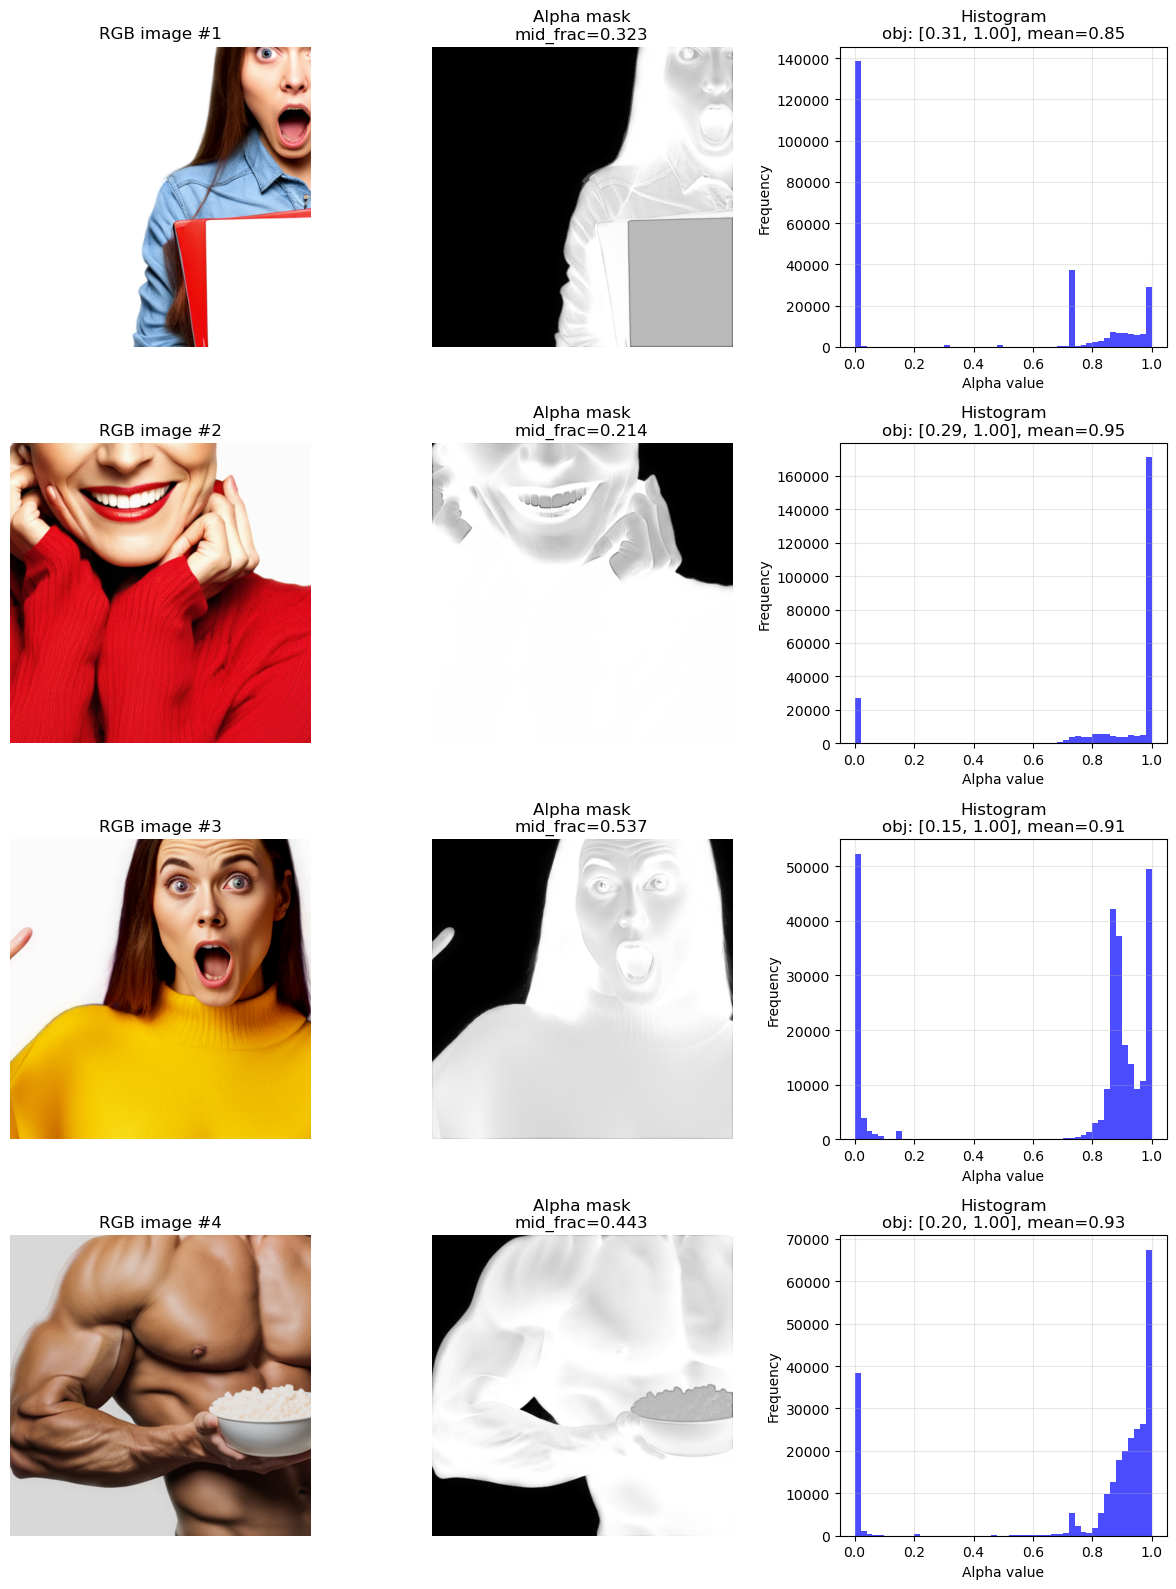


Визуальная проверка:
- Маски должны быть НЕ бинарными (не просто белое/черное)
- Внутри объекта должны быть видны полутона (серые оттенки)
- Гистограмма должна иметь распределение в середине диапазона [0.6-0.95]
- Если маски чисто белые внутри → x-ray аугментация НЕ работает!


In [8]:
import matplotlib.pyplot as plt

# Функция для денормализации изображения
def denorm_img(x):
    """x: [3,H,W] нормализованное -> [H,W,3] в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device, dtype=x.dtype).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device, dtype=x.dtype).view(3, 1, 1)
    x = x * std + mean
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).cpu().numpy()

# Визуализация 6 примеров из train loader
batch = next(iter(train_loader))
imgs = batch["img"]  # (B, 3, H, W)
masks = batch["mask"]  # (B, 1, H, W)

n_show = min(6, imgs.shape[0])

fig, axes = plt.subplots(n_show, 3, figsize=(12, 4*n_show))
if n_show == 1:
    axes = axes.reshape(1, -1)

for i in range(n_show):
    img = denorm_img(imgs[i])
    mask = masks[i, 0].cpu().numpy()
    
    # Статистика маски
    mid_frac = np.mean((mask > 0.05) & (mask < 0.95))
    obj_pixels = mask[mask > 0.1]
    if len(obj_pixels) > 0:
        obj_min = obj_pixels.min()
        obj_max = obj_pixels.max()
        obj_mean = obj_pixels.mean()
    else:
        obj_min = obj_max = obj_mean = 0.0
    
    # RGB изображение
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"RGB image #{i+1}")
    axes[i, 0].axis("off")
    
    # Alpha маска
    axes[i, 1].imshow(mask, cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Alpha mask\nmid_frac={mid_frac:.3f}")
    axes[i, 1].axis("off")
    
    # Гистограмма маски
    axes[i, 2].hist(mask.flatten(), bins=50, range=(0, 1), color='blue', alpha=0.7)
    axes[i, 2].set_title(f"Histogram\nobj: [{obj_min:.2f}, {obj_max:.2f}], mean={obj_mean:.2f}")
    axes[i, 2].set_xlabel("Alpha value")
    axes[i, 2].set_ylabel("Frequency")
    axes[i, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nВизуальная проверка:")
print("- Маски должны быть НЕ бинарными (не просто белое/черное)")
print("- Внутри объекта должны быть видны полутона (серые оттенки)")
print("- Гистограмма должна иметь распределение в середине диапазона [0.6-0.95]")
print("- Если маски чисто белые внутри → x-ray аугментация НЕ работает!")

Проверяем, что пайплайн данных верный

### Визуализация изображений и маттинга из train_processed


In [9]:
train_batch = next(iter(train_loader))
print(train_batch["img"].shape, train_batch["img"].min().item(), train_batch["img"].max().item())
print(train_batch["mask"].shape, train_batch["mask"].min().item(), train_batch["mask"].max().item())
val_batch = next(iter(val_loader))
print(val_batch["img"].shape, val_batch["img"].min().item(), val_batch["img"].max().item())


torch.Size([4, 3, 512, 512]) -2.1179039478302 2.640000104904175
torch.Size([4, 1, 512, 512]) 0.0 1.0
torch.Size([1, 3, 1024, 1024]) -2.1179039478302 2.5354249477386475


### Визуализация shadow-as-alpha аугментации

Показываем примеры изображений с применённой shadow-as-alpha аугментацией для проверки эффекта

In [10]:
def u2net_outputs_to_list(outputs):
    """
    Преобразует выходы модели в список.
    U2NETP возвращает tuple из 7 тензоров: (d0, d1, d2, d3, d4, d5, d6)
    """
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """
    Sobel оператор для вычисления градиентов (краёв).
    x: (B,1,H,W) float [0..1]
    """
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def sobel_mag(x):
    """
    Sobel оператор для вычисления магнитуды градиента.
    x: (H,W) float [0..1]
    """
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def erode(mask01, k=15):
    """
    Эрозия маски через min pooling.
    mask01: (H,W) float [0..1]
    """
    x = mask01[None,None]
    return (-F.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2))[0,0]

def thin_map(alpha01, k=15, thr=0.1):
    """
    Создаёт карту тонких зон (тонкие детали + края).
    alpha01: (H,W) float [0..1]
    """
    obj = (alpha01 > thr).float()
    core = erode(obj, k=k)
    thin = (obj - core).clamp(0,1)  # тонкие зоны + "хрупкие" края
    return thin

def charbonnier(x, eps=1e-3):
    """
    Charbonnier loss (smooth L1).
    x: тензор любого размера
    """
    return torch.sqrt(x*x + eps*eps)

def u2net_mse_loss(outputs, target):
    """
    Улучшенный loss для U2NETP с защитой тонких деталей и чистым фоном.
    
    ОБНОВЛЕНО (2024-12-25, v2):
    - УБРАН entropy_loss (создавал туман на фоне)
    - bg_loss переписан с "haze penalty" через relu(pred - eps)
    - Более агрессивная очистка фона
    
    1) bg-aware: ЖЁСТКИЙ штраф за любые значения > eps на фоне
    2) edge-aware: совпадение градиентов на границах
    3) thin-aware: weighted loss для тонких частей
    4) gradient-aware: детализация внутри объекта
    """
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        # pred, gt: (B,1,H,W) float [0..1]
        pred = out
        gt = target
        
        B, C, H, W = pred.shape
        
        # Базовый MSE loss
        base = F.mse_loss(pred, gt)
        
        # 1) bg-aware: ЖЁСТКИЙ штраф за "туман" на фоне
        # Маска фона (где GT близок к 0)
        bg_mask = (gt <= 0.05).float()  # Расширили порог с 0.01 до 0.05
        
        # "Haze penalty": штрафуем ТОЛЬКО значения выше epsilon
        # relu(pred - eps) = 0 если pred < eps, иначе pred - eps
        eps = 0.02  # Толерантность для микрошумов
        haze = torch.relu(pred - eps)  # Убираем tolerance, штрафуем остальное
        bg_penalty = (haze * haze * bg_mask).sum() / (bg_mask.sum() + 1e-6)
        
        # Обычный MSE на фоне (для значений < eps)
        bg_mse = ((pred * bg_mask).pow(2)).sum() / (bg_mask.sum() + 1e-6)
        
        # Комбинированный bg_loss
        bg_loss = bg_mse + 2.0 * bg_penalty  # Агрессивно штрафуем haze
        
        # 2) edge-aware: заставить совпадать градиенты (границы)
        edge_loss = (sobel(pred) - sobel(gt)).abs().mean()
        
        # 3) thin-aware: weighted loss для тонких частей
        thin_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            pred_alpha = pred[b, 0]  # (H, W)
            
            # Создаём карту тонких зон из GT
            thin = thin_map(gt_alpha, k=21, thr=0.1)  # (H, W)
            
            # Веса: 1.0 для обычных зон, до 5.0 для тонких зон
            w = 1.0 + 4.0 * thin  # (H, W)
            
            # Weighted MSE + Charbonnier для тонких зон
            diff = pred_alpha - gt_alpha  # (H, W)
            thin_mse = (w * diff.pow(2)).mean()
            thin_charb = (w * charbonnier(diff)).mean()
            thin_loss_total += thin_mse + 0.3 * thin_charb
        
        thin_loss = thin_loss_total / B
        
        # 4) gradient-aware: loss на градиенты внутри объекта (детализация)
        gradient_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            pred_alpha = pred[b, 0]  # (H, W)
            
            # Маска объекта
            obj = (gt_alpha > 0.1).float()  # (H, W)
            
            # Градиенты внутри объекта
            gp = sobel_mag(pred_alpha) * obj  # (H, W)
            gg = sobel_mag(gt_alpha) * obj    # (H, W)
            
            gradient_loss_total += (gp - gg).abs().mean()
        
        gradient_loss = gradient_loss_total / B
        
        # Итоговый loss (БЕЗ entropy!):
        # - base MSE: 1.0 (главный)
        # - edge: 0.2 (границы)
        # - bg: 0.5 (УВЕЛИЧЕНО! очень важно для чистого фона)
        # - thin: 0.5 (тонкие детали)
        # - gradient: 0.2 (детализация)
        loss = base + 0.2 * edge_loss + 0.5 * bg_loss + 0.5 * thin_loss + 0.2 * gradient_loss
        
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """
    Метрика MSE по главному выходу (d0).
    """
    out0 = u2net_outputs_to_list(outputs)[0]
    return F.mse_loss(out0, target)

### 🔧 X-ray аугментация - УСИЛЕННАЯ для максимальной детализации

**Проблема**: mid_frac=0.115 (слишком мало полутонов), маска однородная.

**Решение - УСИЛЕННЫЕ параметры**:

1. **Увеличена сила затемнения**: strength (0.40, 0.85) → **(0.50, 0.90)**
2. **Снижен floor**: (0.30, 0.60) → **(0.25, 0.55)** — допускаем более тёмные зоны
3. **Уменьшен blur**: 15 → **10** — ещё больше деталей
4. **Увеличен gamma**: (2.0, 3.2) → **(2.2, 3.5)** — резче контраст
5. **Увеличен black_level**: (0.08, 0.18) → **(0.10, 0.22)** — больше чёрных зон
6. **МАКСИМАЛЬНЫЕ веса градиентов**: w2=(0.5, 0.8) → **(0.6, 0.9)**
7. **МИНИМАЛЬНЫЕ веса luma**: w1=(0.1, 0.3) → **(0.05, 0.2)**
8. **Меньший blur для градиентов**: blur_k//5 → **blur_k//6** (2px вместо 3px)
9. **Меньший финальный blur**: blur_k//3 → **blur_k//4** (3px вместо 5px)

**Ожидаемый результат**:
- mid_frac > 0.3 (было 0.115)
- Видимая структура внутри (полосы, складки)
- Контраст 0.25-0.9 (не 0.7-1.0)

**Если всё ещё недостаточно**:
- Увеличь w2 до (0.7, 0.95)
- Уменьши blur_k до 7 или 5
- Уменьши floor до (0.20, 0.50)

## 3.Модель U2NETP + загрузка pretrained

Инициализация модели и pretrained весов

In [11]:
u2net_path = Path("U-2-Net")
if str(u2net_path.absolute()) not in sys.path:
    sys.path.insert(0, str(u2net_path.absolute()))

from model.u2net import U2NETP  
import torch

model = U2NETP(in_ch=3, out_ch=1).to(device)

# Путь к чекпойнту тоже нужно исправить
ckpt_path = Path("U-2-Net/saved_models/u2netp/u2netp.pth")
ckpt = torch.load(ckpt_path, map_location="cpu")
# иногда в чекпойнте просто state_dict, иногда dict со state_dict
state = ckpt if isinstance(ckpt, dict) and "state_dict" not in ckpt else ckpt.get("state_dict", ckpt)
model.load_state_dict(state, strict=True)

<All keys matched successfully>

## 4. Loss / Metric для U2NETP

In [12]:
def u2net_outputs_to_list(outputs):
    """
    Преобразует выходы модели в список.
    U2NETP возвращает tuple из 7 тензоров: (d0, d1, d2, d3, d4, d5, d6)
    """
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """
    Sobel оператор для вычисления градиентов (краёв).
    x: (B,1,H,W) float [0..1]
    """
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def sobel_mag(x):
    """
    Sobel оператор для вычисления магнитуды градиента.
    x: (H,W) float [0..1]
    """
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    xx = x[None,None]
    gx = F.conv2d(xx, kx, padding=1)
    gy = F.conv2d(xx, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)[0,0]

def erode(mask01, k=15):
    """
    Эрозия маски через min pooling.
    mask01: (H,W) float [0..1]
    ИСПРАВЛЕНО: обрезаем результат до исходного размера для избежания ошибок размерности
    """
    H, W = mask01.shape
    x = mask01[None,None]
    result = (-F.max_pool2d(-x, kernel_size=k, stride=1, padding=k//2))[0,0]
    # Обрезаем до исходного размера на случай несоответствия размеров
    if result.shape[0] != H or result.shape[1] != W:
        result = result[:H, :W]
    return result

def thin_map(alpha01, k=15, thr=0.1):
    """
    Создаёт карту тонких зон (тонкие детали + края).
    alpha01: (H,W) float [0..1]
    """
    obj = (alpha01 > thr).float()
    core = erode(obj, k=k)
    # Убеждаемся, что размеры совпадают перед вычитанием
    H, W = obj.shape
    if core.shape[0] != H or core.shape[1] != W:
        core = core[:H, :W]
    thin = (obj - core).clamp(0,1)  # тонкие зоны + "хрупкие" края
    return thin

def charbonnier(x, eps=1e-3):
    """
    Charbonnier loss (smooth L1).
    x: тензор любого размера
    """
    return torch.sqrt(x*x + eps*eps)

def entropy_regularization(pred, obj_mask):
    """
    Entropy regularization для поощрения полутонов внутри объекта.
    Высокая энтропия = больше разнообразия значений = полутона.
    
    pred: (B,1,H,W) float [0..1]
    obj_mask: (B,1,H,W) float [0..1] - маска объекта из GT
    
    Возвращает loss, который МИНИМИЗИРУЕМ (низкая энтропия = плохо).
    Поэтому на самом деле возвращаем отрицательную энтропию.
    """
    # Считаем энтропию внутри объекта
    # Энтропия: H = -sum(p * log(p))
    # Для непрерывных значений используем аппроксимацию через гистограмму
    # Или используем простую аппроксимацию: H ≈ - p * log(p+eps) - (1-p) * log(1-p+eps)
    
    eps = 1e-6
    pred_obj = pred * obj_mask  # Оставляем только объект
    
    # Бинарная энтропия для каждого пикселя внутри объекта
    # H = - p*log(p) - (1-p)*log(1-p)
    entropy = -(pred * torch.log(pred + eps) + (1 - pred) * torch.log(1 - pred + eps))
    entropy_obj = (entropy * obj_mask).sum() / (obj_mask.sum() + eps)
    
    # Возвращаем отрицательную энтропию, чтобы её максимизировать (минимизируя loss)
    # Высокая энтропия = много полутонов = хорошо
    return -entropy_obj

def u2net_mse_loss(outputs, target):
    """
    Улучшенный loss для U2NETP с защитой тонких деталей и поощрением полутонов.
    
    1) bg-aware: штраф за ненулевой фон (вес уменьшен)
    2) edge-aware: заставить совпадать градиенты (границы)
    3) thin-aware: weighted loss для тонких частей (защита от исчезновения)
    4) gradient-aware: loss на градиенты внутри объекта (детализация)
    5) entropy regularization: поощрение полутонов внутри объекта (НОВОЕ!)
    
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        # pred, gt: (B,1,H,W) float [0..1]
        pred = out
        gt = target
        
        B, C, H, W = pred.shape
        
        # Базовый MSE loss
        base = F.mse_loss(pred, gt)
        
        # 1) bg-aware: штраф за ненулевой фон (ВЕС УМЕНЬШЕН с 0.2 до 0.05)
        # Слишком агрессивный bg_loss может толкать к бинарности
        bg_mask = (gt < 0.01).float()  # Маска фона (где GT близок к 0)
        bg_loss = (pred * bg_mask).pow(2).sum() / (bg_mask.sum() + 1e-6)  # MSE на фоне
        
        # 2) edge-aware: заставить совпадать градиенты (границы)
        edge_loss = (sobel(pred) - sobel(gt)).abs().mean()
        
        # 3) thin-aware: weighted loss для тонких частей (защита от исчезновения)
        # УЛУЧШЕНО: kernel 21-31 для лучшего захвата тонких деталей (волосы/границы)
        # Обрабатываем каждый элемент батча отдельно
        thin_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            pred_alpha = pred[b, 0]  # (H, W)
            
            # Создаём карту тонких зон из GT с kernel 21-31 для лучшего захвата тонких деталей
            thin_k = int(torch.empty(1).uniform_(21, 31).item())  # kernel 21-31 для тонких деталей
            thin = thin_map(gt_alpha, k=thin_k, thr=0.1)  # (H, W)
            
            # Веса: 1.0 для обычных зон, до 5.0 для тонких зон
            w = 1.0 + 4.0 * thin  # (H, W)
            
            # Weighted MSE + Charbonnier для тонких зон
            diff = pred_alpha - gt_alpha  # (H, W)
            thin_mse = (w * diff.pow(2)).mean()
            thin_charb = (w * charbonnier(diff)).mean()
            thin_loss_total += thin_mse + 0.3 * thin_charb
        
        thin_loss = thin_loss_total / B
        
        # 4) gradient-aware: loss на градиенты внутри объекта (детализация)
        # УВЕЛИЧЕН вес для лучшей детализации структуры по плотности
        gradient_loss_total = 0.0
        for b in range(B):
            gt_alpha = gt[b, 0]  # (H, W)
            pred_alpha = pred[b, 0]  # (H, W)
            
            # Маска объекта
            obj = (gt_alpha > 0.1).float()  # (H, W)
            
            # Градиенты внутри объекта
            gp = sobel_mag(pred_alpha) * obj  # (H, W)
            gg = sobel_mag(gt_alpha) * obj    # (H, W)
            
            gradient_loss_total += (gp - gg).abs().mean()
        
        gradient_loss = gradient_loss_total / B
        
        # 5) entropy regularization: поощрение полутонов внутри объекта (НОВОЕ!)
        obj_mask = (gt > 0.1).float()  # Маска объекта (B,1,H,W)
        entropy_loss = entropy_regularization(pred, obj_mask)
        
        # Итоговый loss (обновлённые веса):
        # - base MSE: главный компонент
        # - edge: 0.2 (границы важны)
        # - bg: 0.05 (УМЕНЬШЕНО с 0.2, чтобы не толкать к бинарности)
        # - thin: 0.7 (УВЕЛИЧЕНО с 0.5 для тонких деталей - волосы/границы)
        # - gradient: 0.3 (УВЕЛИЧЕНО с 0.2 для детализации структуры по плотности)
        # - entropy: 0.15 (НОВОЕ! поощрение полутонов)
        loss = base + 0.2 * edge_loss + 0.05 * bg_loss + 0.7 * thin_loss + 0.3 * gradient_loss + 0.15 * entropy_loss
        
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """
    Метрика MSE по главному выходу (d0).
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    # метрику считаем по главному выходу (обычно первый, d0)
    out0 = u2net_outputs_to_list(outputs)[0]
    # Модель уже вернула вероятности [0,1], применяем MSE напрямую
    return F.mse_loss(out0, target)

Лосс — MSE+L1 по alpha, метрика — MSE по главному выходу

## 5. Train / Eval loops (с AMP)

AMP экономит VRAM и ускоряет обучение

In [13]:
USE_AMP = False
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="train", leave=False, total=len(loader)):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в train_epoch. Прерываем обучение.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        if USE_AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss += float(loss.detach().item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch(model, loader):
    """
    Стандартная валидация: считает loss/metric на выходах модели.
    """
    model.eval()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в eval_epoch. Прерываем валидацию.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        bs = imgs.size(0)
        total_loss += float(loss.item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch_inference_pipeline(model, loader):
    """
    Валидация через inference pipeline: повторяет тестовый инференс.
    model(img) → mask_uint8 → сравнить с gt в float [0,1]
    Это позволяет понять, где рождается туман/фон - в модели или в конвертации.
    """
    model.eval()
    total_mse = 0.0
    n_samples = 0

    for batch in tqdm(loader, desc="val-infer", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks_gt = batch["mask"].to(device, non_blocking=True)  # [B, 1, H, W] в [0, 1]

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
            probs = out0  # [B, 1, H, W] в [0, 1]

        # Повторяем тестовый инференс pipeline
        for b in range(probs.size(0)):
            pred = probs[b, 0].cpu().numpy()  # [H, W] в [0, 1]
            
            # Конвертация в uint8 [0, 255] как в submission
            mask_uint8 = (pred * 255).astype(np.uint8)
            
            # Обратно в float [0, 1] для сравнения с GT
            mask_pred_float = mask_uint8.astype(np.float32) / 255.0
            
            # GT тоже в numpy для сравнения
            mask_gt_np = masks_gt[b, 0].cpu().numpy()  # [H, W] в [0, 1]
            
            # MSE между предсказанием (после uint8 конвертации) и GT
            mse = np.mean((mask_pred_float - mask_gt_np) ** 2)
            total_mse += mse
            n_samples += 1

    return total_mse / n_samples if n_samples > 0 else 0.0

## 6. Training run + сохранение лучшей модели

In [14]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [15]:
# Оптимизатор AdamW с weight decay для регуляризации
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Scheduler: уменьшает learning rate при отсутствии улучшения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

# Функция для получения уникального имени файла с номером
def get_unique_path(base_path):
    """Если файл существует, добавляет номер (2, 3, ...) к имени"""
    if not base_path.exists():
        return base_path
    
    base_dir = base_path.parent
    base_name = base_path.stem
    base_ext = base_path.suffix
    
    counter = 2
    while True:
        new_path = base_dir / f"{base_name}_{counter}{base_ext}"
        if not new_path.exists():
            return new_path
        counter += 1

best_val_mse = float("inf")
best_path_base = MODEL_DIR / "u2netp_best.pth"
best_path = get_unique_path(best_path_base)  # Получаем уникальное имя при первом сохранении

if RUN_TRAINING:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_mse = train_epoch(model, train_loader, optimizer)
        
        # Стандартная валидация (на выходах модели)
        val_loss, val_mse = eval_epoch(model, val_loader)
        
        # Обновляем learning rate на основе val_mse
        scheduler.step(val_mse)
        current_lr = optimizer.param_groups[0]["lr"]
        
        print(f"Epoch {epoch}: train_mse={train_mse:.6f} val_mse={val_mse:.6f} lr={current_lr:.2e}")

        # Сохраняем лучшую модель по стандартной val_mse
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            # Если это первое сохранение, используем уже полученное уникальное имя
            # Если файл был удалён/перемещён, получаем новое уникальное имя
            if not best_path.exists() and best_path != best_path_base:
                best_path = get_unique_path(best_path_base)
            torch.save({"model_state": model.state_dict()}, best_path)
            print(f"  -> Сохранена лучшая модель: {best_path.name} (val_mse={best_val_mse:.6f})")
else:
    # При загрузке ищем последнюю сохранённую модель (с наибольшим номером)
    best_path_to_load = best_path_base
    if best_path_to_load.exists():
        # Базовая модель существует
        pass
    else:
        # Ищем модель с наибольшим номером
        max_counter = 0
        counter = 2
        while True:
            candidate = MODEL_DIR / f"u2netp_best_{counter}.pth"
            if candidate.exists():
                max_counter = counter
                counter += 1
            else:
                break
        
        if max_counter > 0:
            best_path_to_load = MODEL_DIR / f"u2netp_best_{max_counter}.pth"
    
    if best_path_to_load.exists():
        print(f"Загружаем модель: {best_path_to_load.name}")
        model.load_state_dict(torch.load(best_path_to_load, map_location=device)["model_state"])
    else:
        print(f"Модель не найдена в {MODEL_DIR}")


c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train:   0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 1: train_mse=0.104957 val_mse=0.032427 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.032427)


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 2: train_mse=0.037266 val_mse=0.023344 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.023344)


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 3: train_mse=0.028762 val_mse=0.022775 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.022775)


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 4: train_mse=0.023773 val_mse=0.020599 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.020599)


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 5: train_mse=0.020394 val_mse=0.020226 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.020226)


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 6: train_mse=0.019578 val_mse=0.022599 lr=1.00e-04


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 7: train_mse=0.015910 val_mse=0.021765 lr=1.00e-04


train:   0%|          | 0/250 [00:00<?, ?it/s]

val:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 8: train_mse=0.013991 val_mse=0.018597 lr=1.00e-04
  -> Сохранена лучшая модель: u2netp_best_18.pth (val_mse=0.018597)


In [16]:
# Проверка после исправления: модель должна выдавать finite значения
print("=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===")
model.eval()
batch = next(iter(train_loader))
imgs = batch["img"].to(device)
masks = batch["mask"].to(device)

with torch.no_grad():
    outputs = model(imgs)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    
    print("out0 shape:", out0.shape)
    print("out0 min/max:", out0.min().item(), out0.max().item())
    print("out0 finite:", torch.isfinite(out0).all().item())
    
    # Проверяем loss и metric
    loss = u2net_mse_loss(outputs, masks)
    metric = u2net_mse_metric(outputs, masks)
    
    print("loss:", loss.item())
    print("metric:", metric.item())
    print("loss finite:", torch.isfinite(loss).item())
    print("metric finite:", torch.isfinite(metric).item())

print("\nЕсли все finite=True и значения разумные, то исправление работает!")


=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===
out0 shape: torch.Size([4, 1, 512, 512])
out0 min/max: 2.21102606709489e-12 0.9950518012046814
out0 finite: True
loss: 0.013435998000204563
metric: 0.0026038605719804764
loss finite: True
metric finite: True

Если все finite=True и значения разумные, то исправление работает!


## 7. Быстрая визуализация

GT  min/max/mean: 0.0 1.0 0.36881882
Pred min/max/mean: 1.4795386e-17 0.99611306 0.3434676


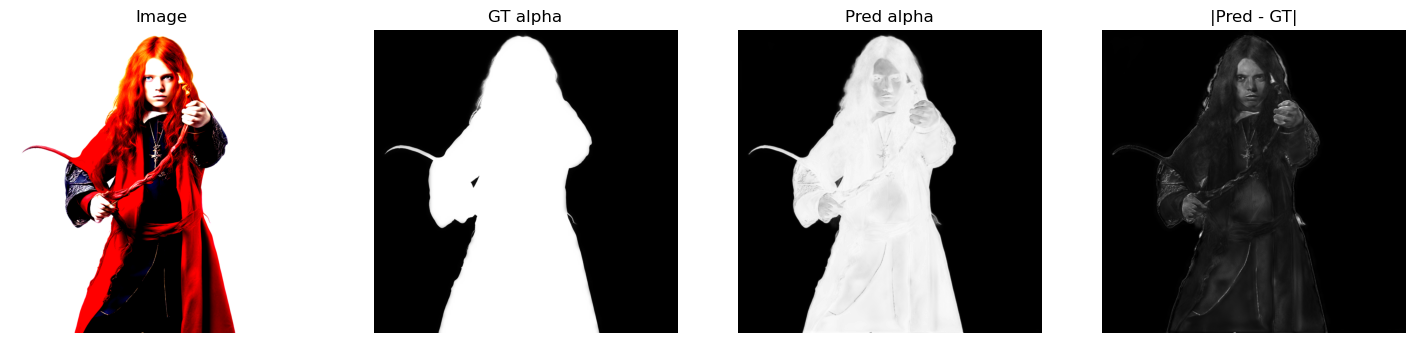

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm_img(x):
    # x: [3,H,W] в [-1,1] -> [H,W,3] в [0,1]
    x = x.detach().cpu()
    x = (x * 0.5 + 0.5).clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

@torch.no_grad()
def predict_alpha(model, img_tensor):
    # img_tensor: [1,3,H,W]
    outputs = model(img_tensor)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    # ИСПРАВЛЕНО: Модель U2NETP уже применяет sigmoid в forward
    # probs = torch.sigmoid(out0)  # СТАРЫЙ КОД с двойным sigmoid
    probs = out0  # [1,1,H,W] in [0,1] - модель уже вернула вероятности
    return probs

def show_val_examples(model, val_loader, n=3):
    model.eval()
    batch = next(iter(val_loader))
    imgs = batch["img"].to(device)
    gts  = batch["mask"].to(device)

    preds = predict_alpha(model, imgs)

    B = imgs.size(0)
    n = min(n, B)

    for i in range(n):
        img_np = denorm_img(imgs[i])
        gt_np  = gts[i,0].detach().cpu().numpy()
        pr_np  = preds[i,0].detach().cpu().numpy()
        print("GT  min/max/mean:", gt_np.min(), gt_np.max(), gt_np.mean())
        print("Pred min/max/mean:", pr_np.min(), pr_np.max(), pr_np.mean())

        diff   = np.abs(pr_np - gt_np)

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        axes[0].imshow(img_np)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(gt_np, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("GT alpha")
        axes[1].axis("off")

        axes[2].imshow(pr_np, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Pred alpha")
        axes[2].axis("off")

        axes[3].imshow(diff, cmap="gray")
        axes[3].set_title("|Pred - GT|")
        axes[3].axis("off")

        plt.show()

# запуск после обучения:
show_val_examples(model, val_loader, n=10)


### Диагностика: анализ сырого инференса

Проверяем, где появляется туман/фон - в модели или в постпроцессе.


=== ДИАГНОСТИКА СЫРОГО ИНФЕРЕНСА (первые 3 изображения) ===

[1] 0001:
  pred01: min=0.0004, max=0.9725
  quantiles [0.01, 0.5, 0.99]: [0.01201853 0.50333887 0.94587398]
  bg_estimate (1% quantile): 0.0120
  mid_frac_pred (доля 0.05-0.95): 0.8781
  mid_frac_uint8 (после uint8): 0.8777
  -> Изменение mid_frac: -0.0005
  ✅ Фон близок к 0 в модели: bg_estimate=0.0120
  ✅ Мягкие края сохраняются после uint8

[2] 0002:
  pred01: min=0.0000, max=0.9753
  quantiles [0.01, 0.5, 0.99]: [1.87889787e-13 3.05188936e-03 9.55979839e-01]
  bg_estimate (1% quantile): 0.0000
  mid_frac_pred (доля 0.05-0.95): 0.3748
  mid_frac_uint8 (после uint8): 0.3811
  -> Изменение mid_frac: 0.0063
  ✅ Фон близок к 0 в модели: bg_estimate=0.0000
  ✅ Мягкие края сохраняются после uint8

[3] 0003:
  pred01: min=0.0199, max=0.9700
  quantiles [0.01, 0.5, 0.99]: [0.3121881  0.68000376 0.90687644]
  bg_estimate (1% quantile): 0.3122
  mid_frac_pred (доля 0.05-0.95): 0.9992
  mid_frac_uint8 (после uint8): 0.9995
  -> Изме

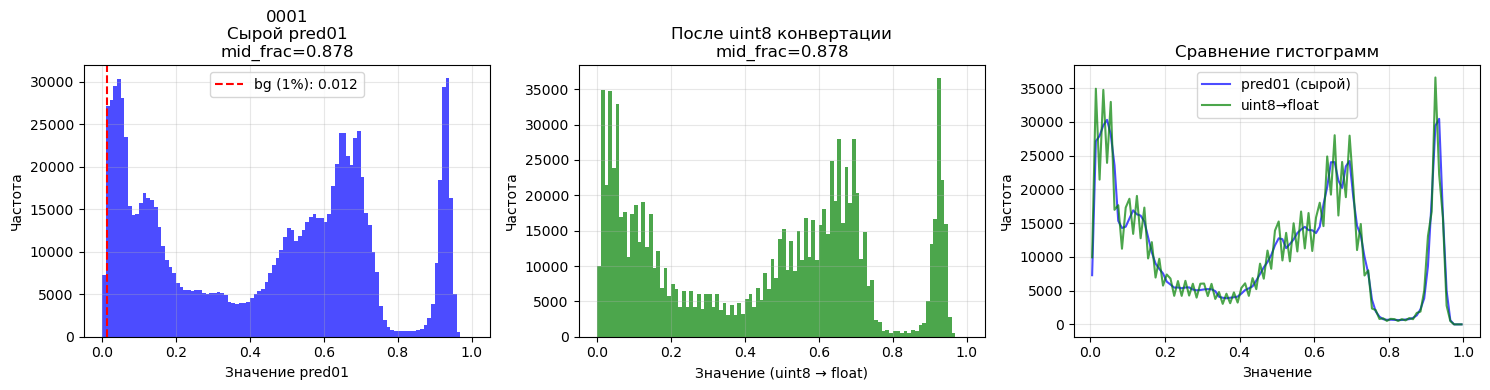

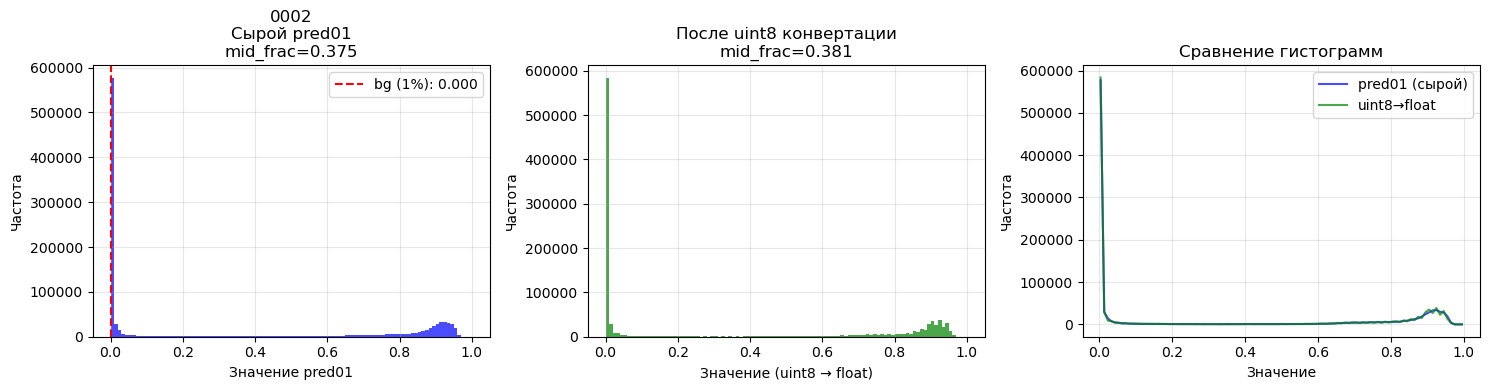

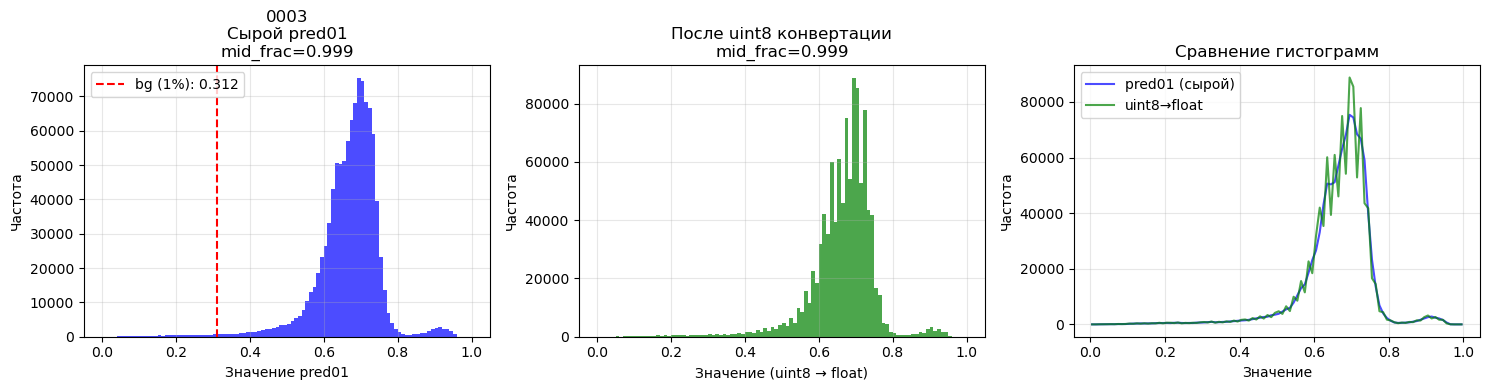

In [18]:
# Шаг 1: "Сырой инференс" без постпроцесса на 2-3 тестовых изображениях
import matplotlib.pyplot as plt

model.eval()
test_dataset = TestImageDataset(TEST_ROOT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

n_diagnostic = min(3, len(test_dataset))
print(f"=== ДИАГНОСТИКА СЫРОГО ИНФЕРЕНСА (первые {n_diagnostic} изображения) ===\n")

results = []

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        if idx >= n_diagnostic:
            break
            
        imgs = batch["img"].to(device)
        names = batch["path"]
        filename = names[0].split(".")[0]
        
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        
        # Сырой выход модели без постпроцесса
        pred01 = out0.squeeze().cpu().numpy()  # [H, W] в диапазоне [0, 1]
        
        # Конвертация в uint8 (как в submission)
        uint8 = (pred01 * 255).clip(0, 255).astype(np.uint8)
        
        # Статистика сырого pred01
        pred_min = pred01.min()
        pred_max = pred01.max()
        quantiles = np.quantile(pred01, [0.01, 0.5, 0.99])
        bg_estimate = np.quantile(pred01, 0.01)  # Оценка фона
        
        # Доля "средних" значений (не бинарных)
        mid_frac_pred = np.mean((pred01 > 0.05) & (pred01 < 0.95))
        
        # После uint8 конвертации
        uint8_back_to_float = uint8.astype(np.float32) / 255.0
        mid_frac_uint8 = np.mean((uint8_back_to_float > 0.05) & (uint8_back_to_float < 0.95))
        
        print(f"[{idx+1}] {filename}:")
        print(f"  pred01: min={pred_min:.4f}, max={pred_max:.4f}")
        print(f"  quantiles [0.01, 0.5, 0.99]: {quantiles}")
        print(f"  bg_estimate (1% quantile): {bg_estimate:.4f}")
        print(f"  mid_frac_pred (доля 0.05-0.95): {mid_frac_pred:.4f}")
        print(f"  mid_frac_uint8 (после uint8): {mid_frac_uint8:.4f}")
        print(f"  -> Изменение mid_frac: {mid_frac_uint8 - mid_frac_pred:.4f}")
        
        # Диагностика фона
        if bg_estimate > 0.10:
            print(f"  ⚠️  ФОН ПОДНЯТ В МОДЕЛИ: bg_estimate={bg_estimate:.4f} > 0.10")
        elif bg_estimate < 0.05:
            print(f"  ✅ Фон близок к 0 в модели: bg_estimate={bg_estimate:.4f}")
        else:
            print(f"  ⚠️  Фон умеренно поднят: bg_estimate={bg_estimate:.4f}")
        
        if mid_frac_uint8 < mid_frac_pred * 0.8:
            print(f"  ⚠️  БИНАРИЗАЦИЯ ПРИ uint8: mid_frac упал с {mid_frac_pred:.4f} до {mid_frac_uint8:.4f}")
        else:
            print(f"  ✅ Мягкие края сохраняются после uint8")
        
        results.append({
            "filename": filename,
            "pred01": pred01,
            "uint8": uint8,
            "bg_estimate": bg_estimate,
            "mid_frac_pred": mid_frac_pred,
            "mid_frac_uint8": mid_frac_uint8
        })
        print()

# Шаг 2: Визуализация гистограмм до/после
print("\n=== ГИСТОГРАММЫ ДО/ПОСЛЕ uint8 КОНВЕРТАЦИИ ===\n")

for idx, res in enumerate(results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Гистограмма pred01 (сырой выход)
    axes[0].hist(res["pred01"].flatten(), bins=100, range=(0, 1), alpha=0.7, color="blue")
    axes[0].axvline(res["bg_estimate"], color="red", linestyle="--", label=f"bg (1%): {res['bg_estimate']:.3f}")
    axes[0].set_xlabel("Значение pred01")
    axes[0].set_ylabel("Частота")
    axes[0].set_title(f"{res['filename']}\nСырой pred01\nmid_frac={res['mid_frac_pred']:.3f}")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Гистограмма после uint8 конвертации
    uint8_float = res["uint8"].astype(np.float32) / 255.0
    axes[1].hist(uint8_float.flatten(), bins=100, range=(0, 1), alpha=0.7, color="green")
    axes[1].set_xlabel("Значение (uint8 → float)")
    axes[1].set_ylabel("Частота")
    axes[1].set_title(f"После uint8 конвертации\nmid_frac={res['mid_frac_uint8']:.3f}")
    axes[1].grid(True, alpha=0.3)
    
    # Сравнение: разница гистограмм
    hist1, bins = np.histogram(res["pred01"].flatten(), bins=100, range=(0, 1))
    hist2, _ = np.histogram(uint8_float.flatten(), bins=100, range=(0, 1))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axes[2].plot(bin_centers, hist1, label="pred01 (сырой)", alpha=0.7, color="blue")
    axes[2].plot(bin_centers, hist2, label="uint8→float", alpha=0.7, color="green")
    axes[2].set_xlabel("Значение")
    axes[2].set_ylabel("Частота")
    axes[2].set_title("Сравнение гистограмм")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print()

print("="*60)


### Inference с flip-TTA и Hysteresis Postprocess

Добавлен flip-TTA для сохранения тонких деталей и **hysteresis postprocess** для удаления "облаков" без бинаризации краёв.

**Flip-TTA:**
1. Предсказание на оригинальном изображении: `pred(x)`
2. Предсказание на горизонтально отражённом изображении: `pred(flip(x))`
3. Отражение результата обратно: `flip(pred(flip(x)))`
4. Усреднение: `(pred(x) + flip(pred(flip(x)))) / 2`

**Hysteresis Postprocess (ОБНОВЛЕНО - эффективная версия с PyTorch):**

Используем **hysteresis** для удаления облаков, которые могут быть связаны с объектом:

1. **Seed** (порог 0.75): "точно объект" - высокая уверенность
2. **Support** (порог 0.08): "возможно объект" - включает полутоновые края
3. **Grow from seed**: итеративная дилатация (30 итераций) от seed только внутри support
   - Использует `F.max_pool2d` для эффективной дилатации
   - Сохраняет мягкие края (полутона)
   - Убирает изолированные "облака" (не достижимы от seed)
4. **Soft mask**: расширяем на 15px (kernel=31) для сохранения краёв
5. **Применение**: `pred = pred * soft_mask` (сохраняем полутона!)

**Преимущества:**
- ✅ Режет облака, даже если они связаны с объектом (не проходят seed)
- ✅ Сохраняет мягкие края и полутона (alpha-matting, не сегментация)
- ✅ Эффективная реализация на PyTorch (быстрее scipy)
- ✅ Не срезает края благодаря расширению маски

In [19]:
model.eval()

# Убрали size - работаем с full-res изображениями
test_dataset = TestImageDataset(TEST_ROOT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

rows = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="test", leave=False):
        imgs = batch["img"].to(device)
        names = batch["path"]
        
        # Flip-TTA: усреднение pred(x) и pred(flip(x))
        # Предсказание на оригинальном изображении
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        probs_orig = out0  # [1, 1, H, W] в [0, 1]
        
        # Предсказание на горизонтально отражённом изображении
        imgs_flip = torch.flip(imgs, dims=[3])  # flip по ширине (dim=3)
        outputs_flip = model(imgs_flip)
        out0_flip = outputs_flip[0] if isinstance(outputs_flip, (list, tuple)) else outputs_flip
        probs_flip = torch.flip(out0_flip, dims=[3])  # flip обратно
        
        # Усреднение предсказаний
        probs = (probs_orig + probs_flip) / 2.0
        
        # Работаем с torch тензором для эффективного hysteresis
        pred = probs[0, 0]  # [H, W] в диапазоне [0, 1], torch tensor
        
        # ОБНОВЛЕНО: Hysteresis постпроцесс (режет облака, не убивает края)
        # Используем PyTorch операции для эффективности
        # seed: pred > 0.75 (точно объект)
        # support: pred > 0.08 (куда можно "расти")
        # Оставляем только то, что достижимо от seed
        
        seed = (pred > 0.75).float()  # точно объект
        supp = (pred > 0.08).float()  # возможно объект (включая полутона)
        
        # Итеративная дилатация от seed внутри support
        m = seed.clone()
        for _ in range(30):  # итерации для роста от seed
            # Дилатация через max_pool2d (kernel=3, stride=1, padding=1)
            dilated = F.max_pool2d(m[None, None], kernel_size=3, stride=1, padding=1)[0, 0]
            # Ограничиваем support - растем только туда, где support > 0
            m = torch.maximum(m, dilated * supp)
        
        # Расширяем маску, чтобы не срезать края (kernel=31, padding=15)
        soft_mask = F.max_pool2d(m[None, None], kernel_size=31, stride=1, padding=15)[0, 0]
        
        # Применяем маску: всё вне soft_mask → 0, внутри → сохраняем полутона
        pred = pred * soft_mask
        
        # Конвертация в numpy для сохранения
        pred_np = pred.cpu().numpy()  # [H, W] в диапазоне [0, 1]
        
        # ВАЖНО: Kaggle считает MSE по маске 0..255 (uint8)
        mask = (pred_np * 255).astype(np.uint8)
        
        # Проверка
        assert mask.dtype == np.uint8, f"mask должен быть uint8, получен {mask.dtype}"
        assert mask.min() >= 0 and mask.max() <= 255, f"mask должен быть [0, 255], получен [{mask.min()}, {mask.max()}]"
        pil_mask = Image.fromarray(mask, mode="L")
        buf = io.BytesIO()
        pil_mask.save(buf, format="PNG")
        image_utf = base64.b64encode(buf.getvalue()).decode("utf-8")
        rows.append({"filename": names[0].split(".")[0], "image_utf": image_utf})

submission = pd.DataFrame(rows)

# Функция для получения уникального имени файла с номером
def get_unique_path(base_path):
    """Если файл существует, добавляет номер (2, 3, ...) к имени"""
    if not base_path.exists():
        return base_path
    
    base_dir = base_path.parent
    base_name = base_path.stem
    base_ext = base_path.suffix
    
    counter = 2
    while True:
        new_path = base_dir / f"{base_name}_{counter}{base_ext}"
        if not new_path.exists():
            return new_path
        counter += 1

# Сохранение submission.csv с проверкой существования
submission_path = MODEL_DIR / "submission.csv"
submission_path = get_unique_path(submission_path)
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

test:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Saved submission to outputs\experiments\exp_001\submission_16.csv


Загружено строк: 100
Колонки: ['filename', 'image_utf']
Первые 3 filename: [1, 2, 3]

[1] 1: shape=(1024, 1024), dtype=uint8, min=0, max=247

[2] 2: shape=(1024, 1024), dtype=uint8, min=0, max=246

[3] 3: shape=(1024, 1024), dtype=uint8, min=0, max=246


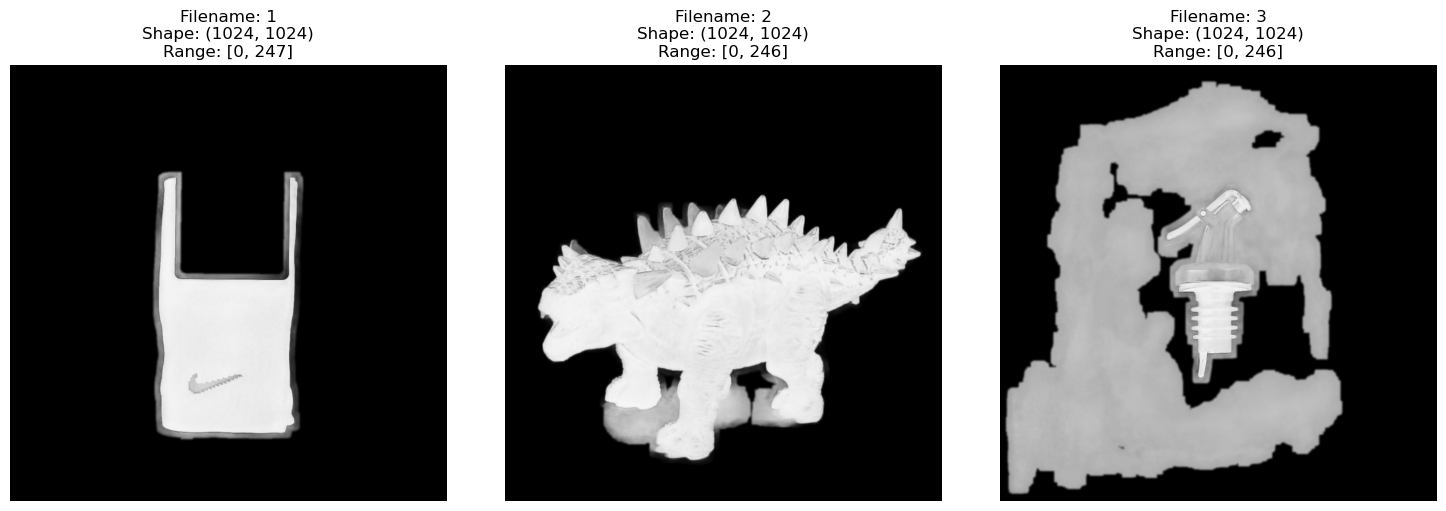


Успешно декодировано и визуализировано 3 изображений из submission.csv


In [23]:
# Визуализация submission.csv - декодирование и отображение предсказанных масок
import base64
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Путь к submission файлу
submission_path = Path("outputs/experiments/exp_001/submission_16.csv")
#submission_path = Path("data/example_submission.csv")

if not submission_path.exists():
    print(f"Файл не найден: {submission_path}")
else:
    df = pd.read_csv(submission_path)
    print(f"Загружено строк: {len(df)}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"Первые 3 filename: {df.head(3)['filename'].tolist()}")

    def decode_png(b64):
        """Декодирует base64 строку в PIL Image"""
        data = base64.b64decode(b64)
        im = Image.open(io.BytesIO(data))
        im.load()
        return im

    # Визуализация первых N изображений
    n_show = min(3, len(df))
    fig, axes = plt.subplots(1, n_show, figsize=(5 * n_show, 5))
    
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        fn = df.loc[i, "filename"]
        b64 = df.loc[i, "image_utf"]
        
        try:
            im = decode_png(b64)
            arr = np.array(im)
            
            axes[i].imshow(arr, cmap="gray", vmin=0, vmax=255)
            axes[i].set_title(f"Filename: {fn}\nShape: {arr.shape}\nRange: [{arr.min()}, {arr.max()}]")
            axes[i].axis("off")
            
            print(f"\n[{i+1}] {fn}: shape={arr.shape}, dtype={arr.dtype}, min={arr.min()}, max={arr.max()}")
        except Exception as e:
            print(f"Ошибка при декодировании {fn}: {e}")
            axes[i].text(0.5, 0.5, f"Error:\n{str(e)}", ha="center", va="center")
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nУспешно декодировано и визуализировано {n_show} изображений из submission.csv")

